# Baseline - модель

**Цель ноутбука:**
- Построить пайплайн обучения
- Применить лучшую из моделей

In [ ]:
import zipfile
import os
import shutil
import random
import gdown

import cv2
from PIL import Image, ImageOps
from skimage.feature import hog

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from tqdm.auto import tqdm

In [ ]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

In [ ]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    DRIVE_DIR = os.path.join("/content/drive", "MyDrive")
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), "dataset")
TEMP_DIR = os.path.join(os.getcwd(), "temp")
ZIP_PATH = os.path.join(DRIVE_DIR, "dataset_32_classes.zip")
os.makedirs(DATASET_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_id = "1FKZ9oHZ3zFMoFJX2f2aI34M2XZ2ikSb0"
if os.path.exists(ZIP_PATH):
    print("Архив уже добавлен")
else:
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        os.path.join(os.getcwd(), "dataset_32_classes.zip"),
        quiet=False,
    )

Архив уже добавлен


In [ ]:
# Распаковка архива
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall("./dataset")

classes = os.listdir(DATASET_DIR)

# Проверим структуру папок
print(f"Количество папок: {len(classes)}")

Количество папок: 32


## Используемые функции подготовки датасета

Данная функция resize_image используется для изменения размера внутри пайплайна модели

In [ ]:
def resize_image(image, size: tuple[int, int]):
    img = Image.fromarray(image)
    if img.mode != "RGB":
        img = img.convert("RGB")
    ratio = img.width / img.height
    # Широкое изображение
    if ratio > 1:
        new_width = size[0]
        new_height = int(size[0] / ratio)
    # Высокое изображение
    else:
        new_height = size[1]
        new_width = int(size[1] * ratio)
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    img_padded = ImageOps.pad(img_resized, size, color="white", centering=(0.5, 0.5))
    return np.array(img_padded)

Прежде чем подавать изображения из датасета на обучение, их стоит привести к единому размеру.

In [ ]:
def set_image_size(img_path: str, save_path: str, size: tuple[int, int]):
    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    ratio = img.width / img.height
    # Широкое изображение
    if ratio > 1:
        new_width = size[0]
        new_height = int(size[0] / ratio)
    # Высокое изображение
    else:
        new_height = size[1]
        new_width = int(size[1] * ratio)
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    img_padded = ImageOps.pad(img_resized, size, color="white", centering=(0.5, 0.5))
    img_padded.save(save_path)

In [ ]:
def create_resized_dataset(size: tuple[int, int]):
    # Если папка уже была, то удалить из нее прошлое содержимое
    if os.path.exists(TEMP_DIR):
        shutil.rmtree(TEMP_DIR)
    os.mkdir(TEMP_DIR)

    for cl in tqdm(classes):

        temp_cl_path = os.path.join(TEMP_DIR, cl)
        if os.path.exists(temp_cl_path) == False:
            os.mkdir(temp_cl_path)

        folder_path = os.path.join(DATASET_DIR, cl)
        image_names = os.listdir(folder_path)
        for img_name in image_names:
            img_path = os.path.join(DATASET_DIR, cl, img_name)
            save_path = os.path.join(TEMP_DIR, cl, img_name)
            set_image_size(img_path, save_path, size)

Т.к. оптимальным для лучшей модели был выбран размер 64*64px, то можно сразу привести датасет к этому размеру

In [ ]:
create_resized_dataset((64, 64))

  0%|          | 0/32 [00:00<?, ?it/s]

Загрузка изображений и разбиение их на трейн и тест

In [ ]:
def load_colored_images_and_labels(dataset_path: str):
    images = []
    labels = []
    classes = os.listdir(dataset_path)
    for class_label in tqdm(classes):
        class_folder = os.path.join(dataset_path, class_label)
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB
            images.append(img)
            labels.append(class_label)
    images_arr = np.array(images)
    labels_arr = np.array(labels)
    return images_arr, labels_arr

In [ ]:
images, labels = load_colored_images_and_labels(TEMP_DIR)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=RANDOM_STATE
)

## Пайплайн модели

Для извлечения признаков используется HOG. Был создан класс HogTransformer, который выделит признаки перед обучением и предсказанием для модели.

In [ ]:
def extract_hog_color_features(
    images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), size=(64, 64)
):
    hog_features = []
    for image in images:
        img_hog_features = []
        resized_image = resize_image(image, size)
        for channel in cv2.split(resized_image):
            features = hog(
                channel,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm="L2-Hys",
                visualize=False,
            )
            img_hog_features.append(features)
        hog_features.append(np.hstack(img_hog_features))
    return np.array(hog_features)

In [ ]:
class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self, orientations=3, pixels_per_cell=(10, 10), cells_per_block=(2, 2), size=(64, 64)
    ):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.size = size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return extract_hog_color_features(
            X,
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            size=self.size,
        )

    def predict(self, X):
        return self.transform(X)

### Применение модели

В качестве базовой модели был выбран SVC. Метод опорных векторов показал лучшие метрики accuracy и f1 macro.

В пайплайн был добавлен PCA для уменьшения размерности данных. Это позволило быстрее обучать модель без сильной потере в качесте.

In [ ]:
hog_transformer = HogTransformer(
    orientations=3, pixels_per_cell=(10, 10), cells_per_block=(2, 2), size=(64, 64)
)
pca = PCA(n_components=0.6)
svc = SVC()
hog_svc = make_pipeline(hog_transformer, pca, svc)

In [ ]:
hog_svc.fit(X_train, y_train)

Pipeline(steps=[('hogtransformer', HogTransformer()),
                ('pca', PCA(n_components=0.6)), ('svc', SVC())])

In [ ]:
pred_test = hog_svc.predict(X_test)

Проверим метрики...

In [ ]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

       Apple       0.57      0.38      0.46       296
     Avocado       0.60      0.50      0.55       284
      Banana       0.79      0.57      0.66       295
        Bean       0.50      0.43      0.46       266
Bitter_Gourd       0.39      0.81      0.52       266
Bottle_Gourd       0.79      0.81      0.80       302
     Brinjal       0.44      0.42      0.43       294
    Broccoli       0.42      0.58      0.49       259
     Cabbage       0.31      0.31      0.31       252
    Capsicum       0.48      0.63      0.55       273
      Carrot       0.64      0.71      0.68       261
 Cauliflower       0.73      0.56      0.63       277
      Cherry       0.63      0.44      0.51       271
    Cucumber       0.84      0.59      0.69       259
       Grape       0.92      1.00      0.96       277
        Kiwi       0.61      0.60      0.60       289
       Mango       0.62      0.55      0.58       303
         Nut       0.95    

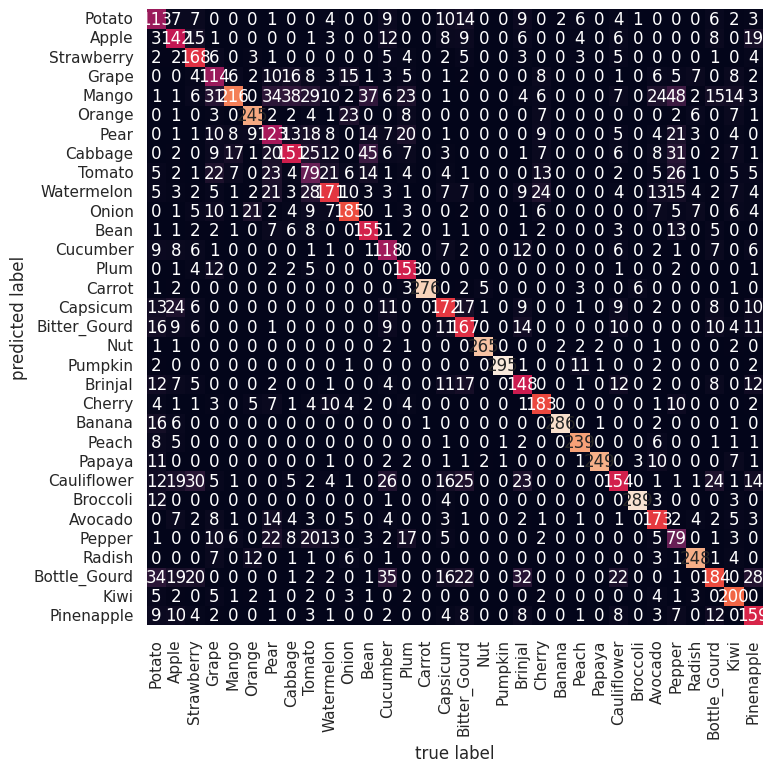

In [ ]:
plt.figure(figsize=(8, 8))
mat = confusion_matrix(y_test, pred_test)
sns.heatmap(
    mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=classes, yticklabels=classes
)
plt.xlabel("true label")
plt.ylabel("predicted label");

Предсказания на трейне

In [ ]:
pred_train = hog_svc.predict(X_train)
accuracy_score(y_train, pred_train)

0.6950613839285714